In [498]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import  HillClimbSearch, BicScore
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pgmpy.inference import VariableElimination
from pgmpy.estimators import TreeSearch
from sklearn.preprocessing import KBinsDiscretizer
import networkx as nx
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest, f_regression



# EDA and Preprocessing

In [499]:
train_data_path = '.\\Data\\train.csv'
test_data_path = '.\\Data\\test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
temp_data = train_data.copy()

RandomState = 42

train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,2
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,0
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,1
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,0


In [500]:
print(len(train_data))
print(len(test_data))
print(len(train_data) + len(test_data))

8523
5681
14204


In [501]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      8523 non-null   object 
 1   X2      7060 non-null   float64
 2   X3      8523 non-null   object 
 3   X4      8523 non-null   float64
 4   X5      8523 non-null   object 
 5   X6      8523 non-null   float64
 6   X7      8523 non-null   object 
 7   X8      8523 non-null   int64  
 8   X9      6113 non-null   object 
 9   X10     8523 non-null   object 
 10  Y       8523 non-null   int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 732.6+ KB


In [502]:
train_data.describe()

,X2,X4,X6,X8,Y
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,0.673941
std,4.643456,0.051598,62.275067,8.371760,1.046831
min,4.555000,0.000000,31.290000,1985.000000,0.000000
25%,8.773750,0.026989,93.826500,1987.000000,0.000000
50%,12.600000,0.053931,143.012800,1999.000000,0.000000
75%,16.850000,0.094585,185.643700,2004.000000,1.000000
max,21.350000,0.328391,266.888400,2009.000000,3.000000


## max and min values accross all numeric columns do not require a 64 bits container, therefore i'll reduce the container sizes to improve efficiency

In [503]:
train_data.X2 = train_data.X2.astype(np.float32)
train_data.X4 = train_data.X4.astype(np.float32)
train_data.X6 = train_data.X6.astype(np.float32)
train_data.X8 = train_data.X8.astype(np.int32)
train_data.Y = train_data.Y.astype(np.int8)

In [504]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.809204,OUT049,1999,Medium,Tier 1,0
1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,2
2,FDN15,17.500000,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,0
3,FDX07,19.200001,Regular,0.000000,Fruits and Vegetables,182.095001,OUT010,1998,NaN,Tier 3,1
4,NCD19,8.930000,Low Fat,0.000000,Household,53.861401,OUT013,1987,High,Tier 3,0


In [505]:
train_data.nunique()

X1     1559
X2      415
X3        5
X4     7879
X5       16
X6     5938
X7       10
X8        9
X9        3
X10       3
Y         4
dtype: int64

In [506]:
train_data.X3.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

'Low Fat', 'low fat' and 'LF' all stand for the same thing
and same goes for 'Regular' and 'reg'

In [507]:
train_data.X3.replace(['Low Fat', 'low fat'], 'LF', inplace=True)
train_data.X3.replace(['Regular', 'reg'], 'R', inplace=True) 

In [508]:
train_data.X5.unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

### looking at the unique values of X5, the data is clearly related to food products

In [509]:
train_data.X7.unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

### we can get rid of the substring 'OUT' since it's just repeated

In [510]:
train_data.X7 = train_data.X7.apply(lambda x : x[3:])

### apparently X7 is not a unique identifier

In [511]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,FDA15,9.300000,LF,0.016047,Dairy,249.809204,049,1999,Medium,Tier 1,0
1,DRC01,5.920000,R,0.019278,Soft Drinks,48.269199,018,2009,Medium,Tier 3,2
2,FDN15,17.500000,LF,0.016760,Meat,141.617996,049,1999,Medium,Tier 1,0
3,FDX07,19.200001,R,0.000000,Fruits and Vegetables,182.095001,010,1998,NaN,Tier 3,1
4,NCD19,8.930000,LF,0.000000,Household,53.861401,013,1987,High,Tier 3,0


In [512]:
train_data.X1.unique()

array(['FDA15', 'DRC01', 'FDN15', ..., 'NCF55', 'NCW30', 'NCW05'],
      dtype=object)

### after researching, it seems like the abbreviations in X1 act as identifiers for the product type, though they can't be considered as unique identifiers since there are less unique values than there are records in the dataset.
 

In [513]:
train_data.X1.to_numpy()[0]

'FDA15'

In [514]:
re.match(r'^[a-zA-Z]{3}\d{2}$', train_data.X1.to_numpy()[0])

<re.Match object; span=(0, 5), match='FDA15'>

In [515]:
def check_if_all_strings_have_the_same_format(iterable: np.ndarray[str], regex: str):
    matches = []
    for elem in iterable:
        match_ = re.match(regex, elem)
        matches.append(match_)

    print("all strings have the same format") if all(matches) else print("not all the string have the same format")


In [516]:
check_if_all_strings_have_the_same_format(train_data.X1.to_numpy(), r'^[a-zA-Z]{3}\d{2}$')

all strings have the same format


### apparently, all records in X1 have the same format which consists of 3 chars followed by 2 digits s.t. the chars refer to some product type, and the digits are product identifiers

## Extracting the product type identifier abbreviation as a feature as it might be helpful in predicting the label

In [517]:
train_data['ProductType'] = train_data.X1.apply(lambda x : x[0:3])

In [518]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,9.300000,LF,0.016047,Dairy,249.809204,049,1999,Medium,Tier 1,0,FDA
1,DRC01,5.920000,R,0.019278,Soft Drinks,48.269199,018,2009,Medium,Tier 3,2,DRC
2,FDN15,17.500000,LF,0.016760,Meat,141.617996,049,1999,Medium,Tier 1,0,FDN
3,FDX07,19.200001,R,0.000000,Fruits and Vegetables,182.095001,010,1998,NaN,Tier 3,1,FDX
4,NCD19,8.930000,LF,0.000000,Household,53.861401,013,1987,High,Tier 3,0,NCD


In [519]:
(train_data.X1 + train_data.X7).nunique()

8523

## X1 concatenated with X7 form a unique identifier for each record in the dataset

In [520]:
train_data.X1.value_counts()

X1
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

<Axes: xlabel='ProductType'>

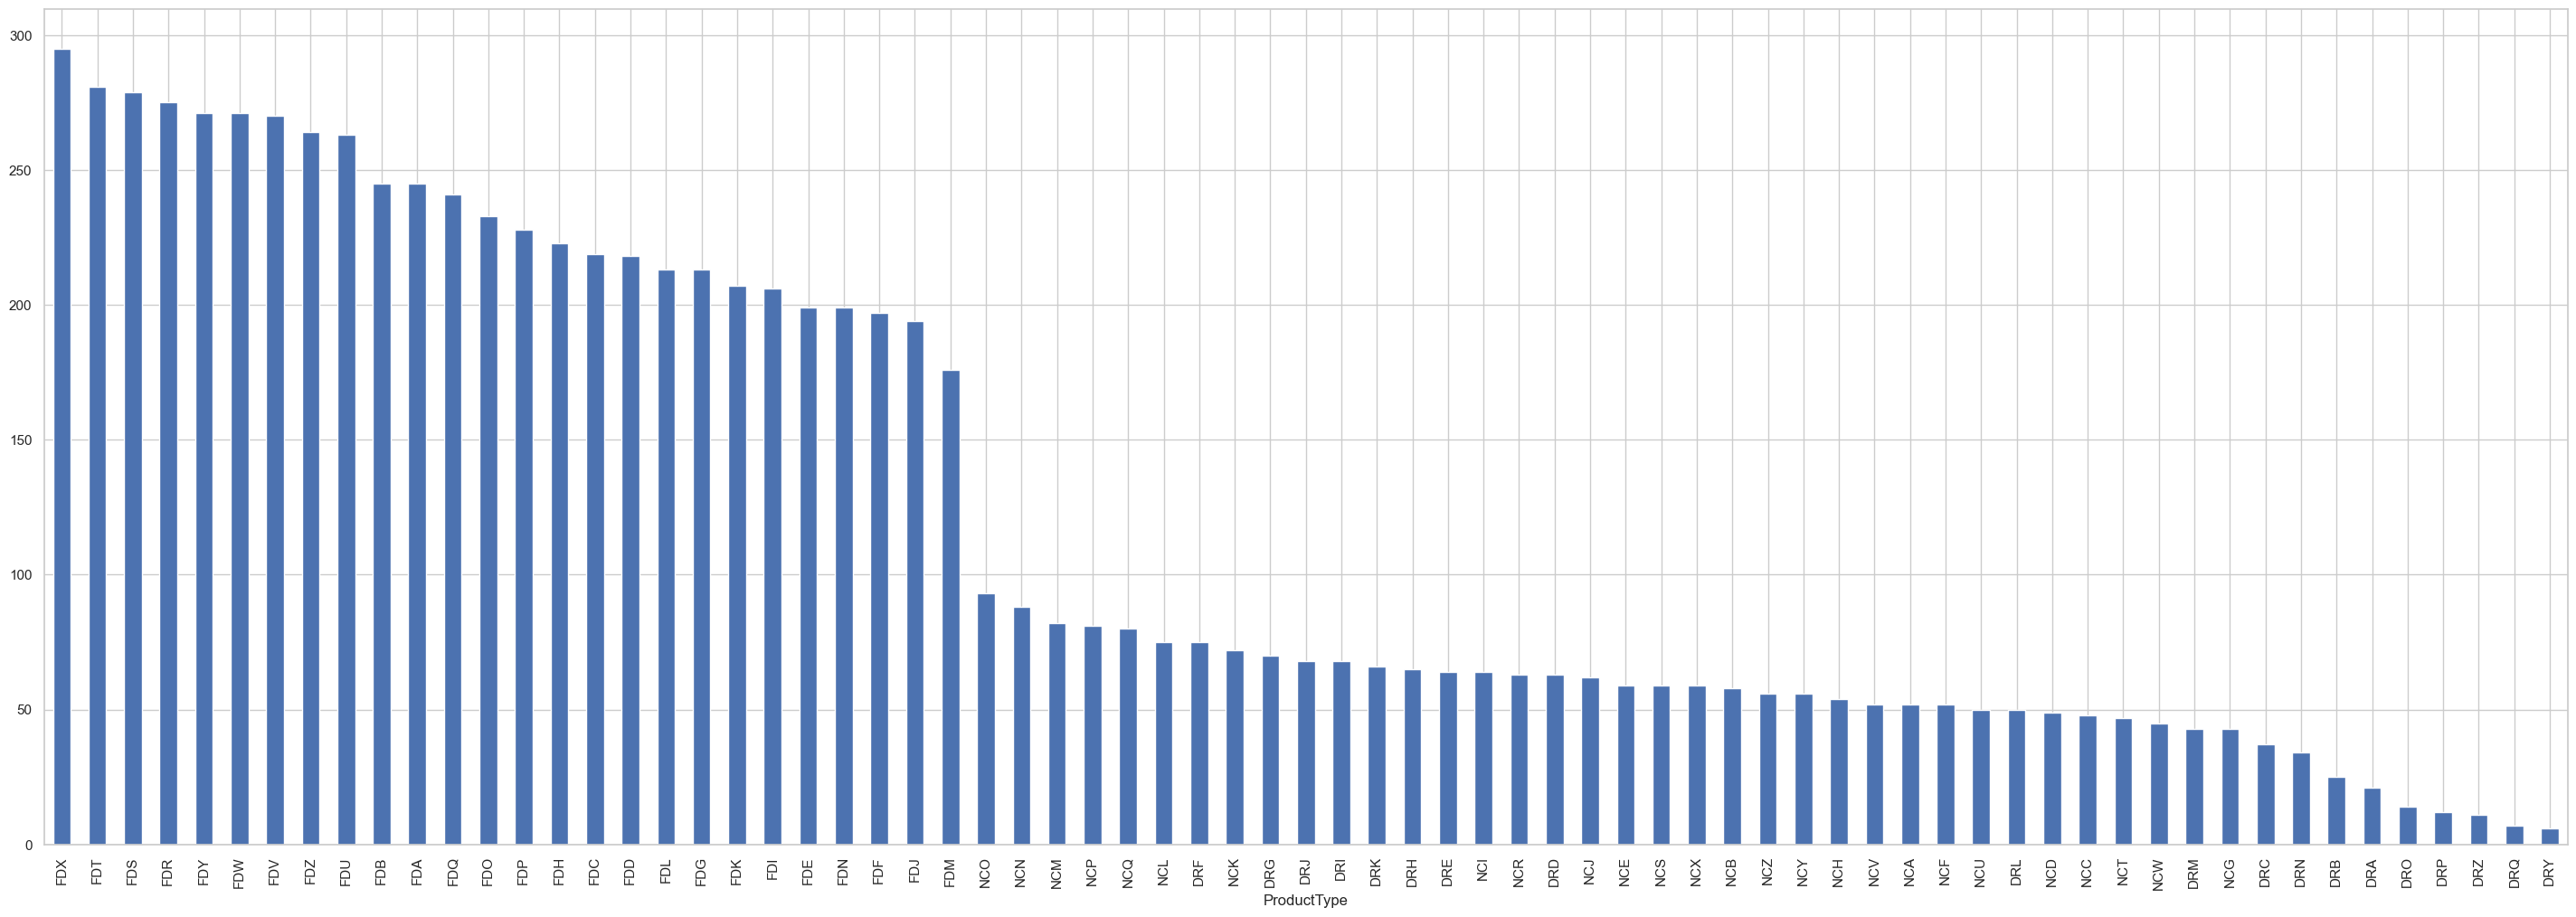

In [521]:
plt.figure(figsize=(36,12))
train_data.ProductType.value_counts().plot(kind='bar')

## FDX and FDT are the most common products types
## Product Types that start with DR are the least common products types

In [522]:
group_ = train_data.groupby('ProductType')['X5'].unique() 
print('FDX:', group_['FDX'])
print('FDT:', group_['FDT'])
print('FDT:', group_['FDS'])
print('FDT:', group_['FDR'])
print('*'*50)
print('NCN:', group_['NCN'])
print('NCM:', group_['NCM'])
print('NCO:', group_['NCO'])
print('NCQ:', group_['NCQ'])
print('NCJ:', group_['NCJ'])
print('*'*50)
print('DRY:', group_['DRY'])
print('DRQ:', group_['DRQ'])
print('DRZ:', group_['DRZ'])
print('DRP:', group_['DRP'])
print('DRO:', group_['DRO'])
print('DRB:', group_['DRB'])

FDX: ['Fruits and Vegetables' 'Snack Foods' 'Canned' 'Frozen Foods' 'Meat'
 'Baking Goods' 'Dairy' 'Breads']
FDT: ['Frozen Foods' 'Baking Goods' 'Fruits and Vegetables' 'Canned' 'Meat'
 'Snack Foods' 'Breads' 'Dairy']
FDT: ['Snack Foods' 'Dairy' 'Frozen Foods' 'Fruits and Vegetables' 'Canned'
 'Baking Goods' 'Meat' 'Breads']
FDT: ['Frozen Foods' 'Canned' 'Baking Goods' 'Fruits and Vegetables' 'Breads'
 'Dairy' 'Snack Foods' 'Meat' 'Breakfast']
**************************************************
NCN: ['Others' 'Household' 'Health and Hygiene']
NCM: ['Others' 'Health and Hygiene' 'Household']
NCO: ['Household' 'Others' 'Health and Hygiene']
NCQ: ['Household' 'Others' 'Health and Hygiene']
NCJ: ['Health and Hygiene' 'Household' 'Others']
**************************************************
DRY: ['Soft Drinks']
DRQ: ['Hard Drinks']
DRZ: ['Soft Drinks']
DRP: ['Hard Drinks']
DRO: ['Hard Drinks']
DRB: ['Soft Drinks']


## All the Product Types starting with DR are related to Drink products so it seems like DR stands for DRINK
## FDX and FDT the more common ones, have more diverse products, but mostly they are food products, so it seems like FD stands for FOOD
## products starting with NC are related to Household and 'Health and Hygiene' products

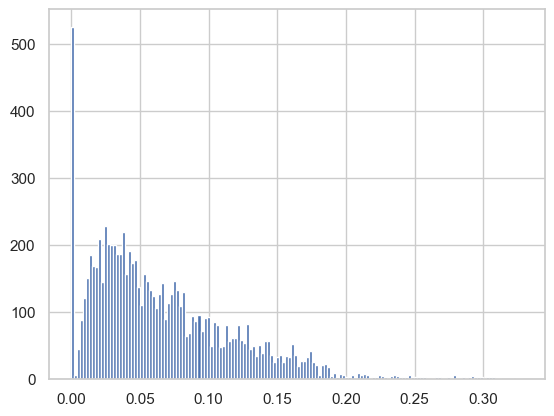

In [523]:
plt.hist(train_data.X4,bins=150);

In [524]:
train_data.X4.min()

0.0

### X4 is left skewed, some proposed solutions are log transform, square root [applicable since all values are positive], cubic root, and box-cox transformation

In [525]:
train_data.X4 = train_data.X4.apply(lambda x : np.cbrt(x))

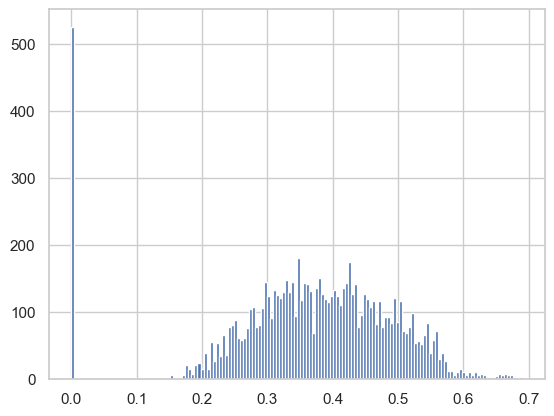

In [526]:
plt.hist(train_data.X4,bins=150); # the ; prevents some unnecessary logs that show up

after trial and error, cubic root transformation gave out the best results of eliminating skewness in the feature

In [527]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,9.300000,LF,0.252232,Dairy,249.809204,049,1999,Medium,Tier 1,0,FDA
1,DRC01,5.920000,R,0.268136,Soft Drinks,48.269199,018,2009,Medium,Tier 3,2,DRC
2,FDN15,17.500000,LF,0.255913,Meat,141.617996,049,1999,Medium,Tier 1,0,FDN
3,FDX07,19.200001,R,0.000000,Fruits and Vegetables,182.095001,010,1998,NaN,Tier 3,1,FDX
4,NCD19,8.930000,LF,0.000000,Household,53.861401,013,1987,High,Tier 3,0,NCD


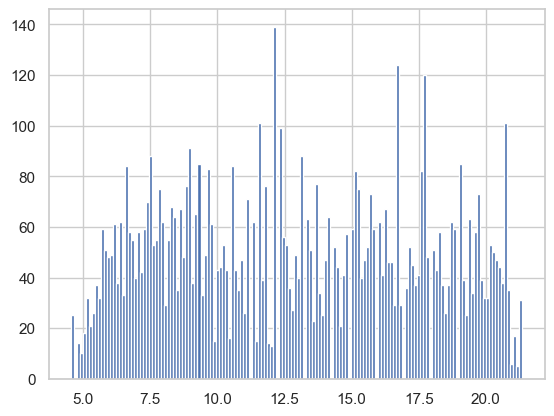

In [528]:
plt.hist(train_data.X2,bins=150);

Nothing special about this one

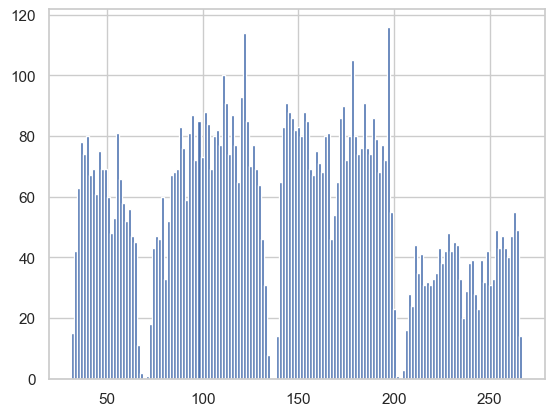

In [529]:
plt.hist(train_data.X6,bins=150);

it seems like each value of X6 fall within 1 of 4 intervals: ~ [20-70], [70-135], [135-200], [200, 270]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


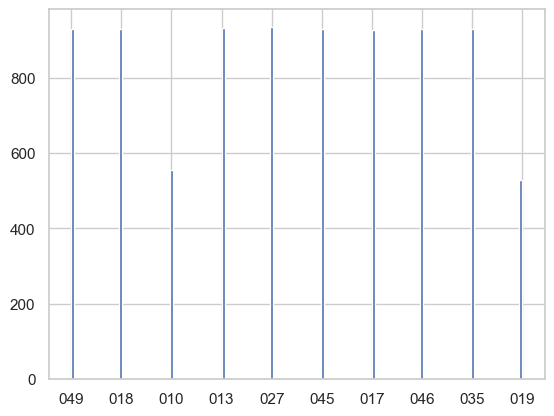

In [530]:
plt.hist(train_data.X7,bins=150);


Nothing special

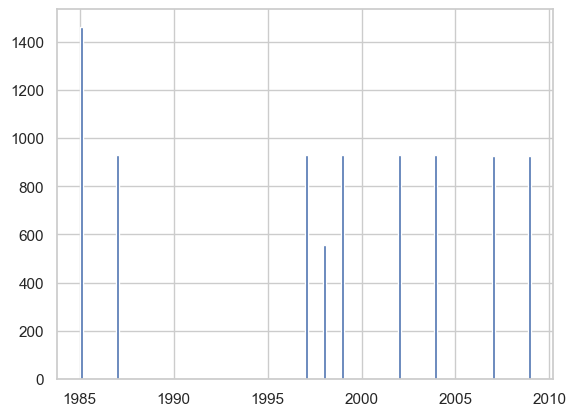

In [531]:
plt.hist(train_data.X8,bins=150);


In [532]:
train_data.groupby('X1')['X8'].unique() 

X1
DRA12          [2007, 2002, 1987, 2004, 2009, 1998]
DRA24          [2007, 1985, 1998, 2004, 1999, 1987]
DRA59    [1997, 1999, 1987, 2007, 1985, 2009, 1998]
DRB01                            [1999, 1987, 1985]
DRB13                [2007, 2004, 1998, 1987, 1999]
                            ...                    
NCZ30    [1998, 1987, 2004, 2007, 1999, 1985, 2002]
NCZ41                [1987, 2004, 2002, 2007, 2009]
NCZ42                [1998, 2007, 1987, 2004, 1999]
NCZ53                [2009, 1985, 1987, 1998, 1999]
NCZ54          [1998, 1985, 2002, 1997, 2009, 1999]
Name: X8, Length: 1559, dtype: object

Assuming each value in X1 act as a product identifier, we can't say that X8 represents the year of which that product was, say, registered, since each product identifier have different X8 values.

In [533]:
dates_verification = train_data.groupby('ProductType')['X8']

In [534]:
dates_verification.unique()

ProductType
DRA    [2007, 2002, 1987, 2004, 1997, 1985, 1999, 199...
DRB    [1987, 1985, 1997, 2004, 2007, 1998, 1999, 200...
DRC    [2009, 2004, 2007, 1985, 2002, 1997, 1998, 198...
DRD    [2007, 2009, 2004, 1985, 2002, 1997, 1987, 199...
DRE    [1985, 2007, 2002, 1997, 2004, 1999, 1987, 199...
                             ...                        
NCV    [2007, 1999, 1985, 1997, 1998, 1987, 2009, 200...
NCW    [1999, 1985, 2007, 1998, 2009, 1997, 2002, 198...
NCX    [1999, 2002, 2007, 1985, 1997, 1987, 1998, 200...
NCY    [1987, 2002, 2004, 1999, 1997, 1998, 2007, 198...
NCZ    [1999, 1998, 2004, 1985, 1987, 2002, 2007, 200...
Name: X8, Length: 71, dtype: object

## There's no significant relationship between X1/Product Type and X8

In [535]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,9.300000,LF,0.252232,Dairy,249.809204,049,1999,Medium,Tier 1,0,FDA
1,DRC01,5.920000,R,0.268136,Soft Drinks,48.269199,018,2009,Medium,Tier 3,2,DRC
2,FDN15,17.500000,LF,0.255913,Meat,141.617996,049,1999,Medium,Tier 1,0,FDN
3,FDX07,19.200001,R,0.000000,Fruits and Vegetables,182.095001,010,1998,NaN,Tier 3,1,FDX
4,NCD19,8.930000,LF,0.000000,Household,53.861401,013,1987,High,Tier 3,0,NCD


<Axes: xlabel='X5'>

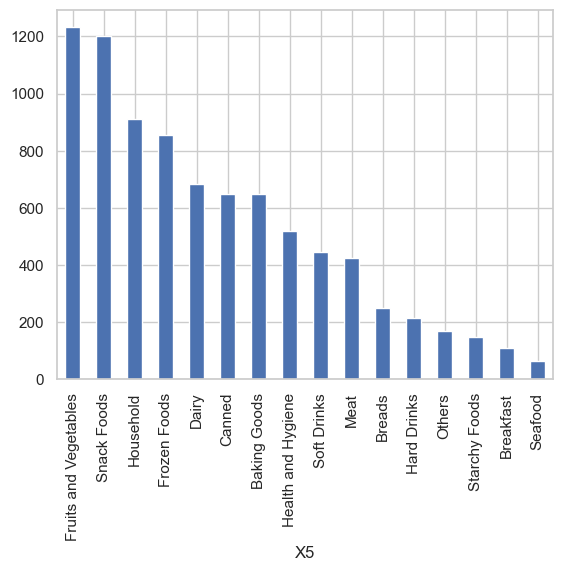

In [536]:
train_data.X5.value_counts().plot(kind='bar')

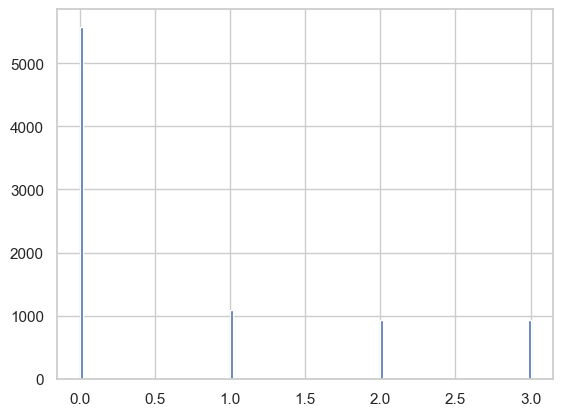

In [537]:
plt.hist(train_data.Y,bins=150);

# The dataset is completely unbalanced, either down sampling or upsampling will be used

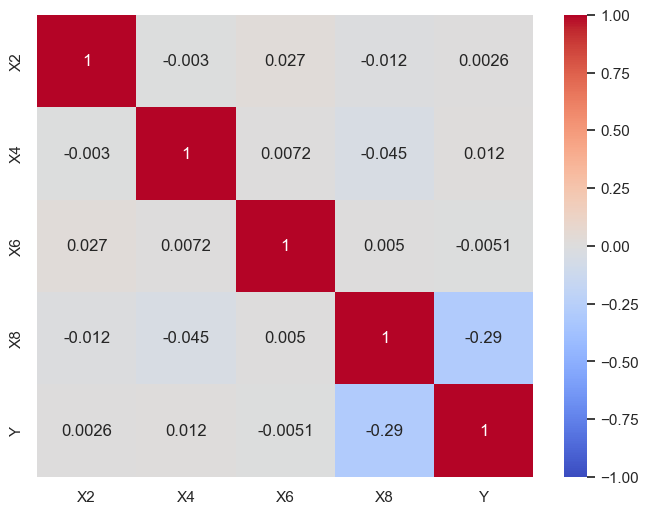

In [538]:
corr_matrix = train_data.select_dtypes(['number']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [539]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,9.300000,LF,0.252232,Dairy,249.809204,049,1999,Medium,Tier 1,0,FDA
1,DRC01,5.920000,R,0.268136,Soft Drinks,48.269199,018,2009,Medium,Tier 3,2,DRC
2,FDN15,17.500000,LF,0.255913,Meat,141.617996,049,1999,Medium,Tier 1,0,FDN
3,FDX07,19.200001,R,0.000000,Fruits and Vegetables,182.095001,010,1998,NaN,Tier 3,1,FDX
4,NCD19,8.930000,LF,0.000000,Household,53.861401,013,1987,High,Tier 3,0,NCD


In [540]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   X1           8523 non-null   object 
 1   X2           7060 non-null   float32
 2   X3           8523 non-null   object 
 3   X4           8523 non-null   float64
 4   X5           8523 non-null   object 
 5   X6           8523 non-null   float32
 6   X7           8523 non-null   object 
 7   X8           8523 non-null   int32  
 8   X9           6113 non-null   object 
 9   X10          8523 non-null   object 
 10  Y            8523 non-null   int8   
 11  ProductType  8523 non-null   object 
dtypes: float32(2), float64(1), int32(1), int8(1), object(7)
memory usage: 641.0+ KB


In [541]:
## Filling nulls [avg, mod]
## Encoding [X3 -> 0,1 ||| x9 -> ordinal encoding, x10 ordinal encoding, X5 label encoding]
## Standardization

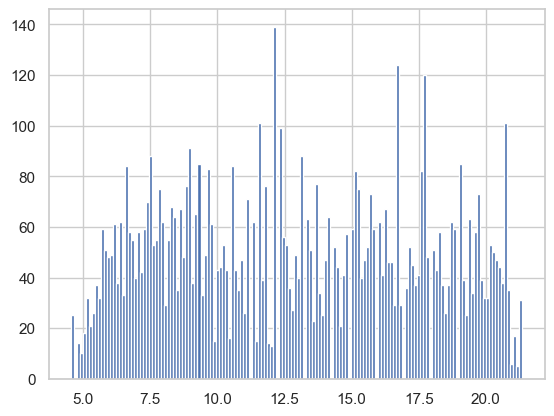

In [542]:
plt.hist(train_data.X2,bins=150);

# Further Preprocessing

In [543]:
sum(train_data['X4']==0)

526

In [544]:
# replace  0 with NaN
train_data['X4'] = train_data['X4'].replace(0, np.nan)
train_data_copy = train_data.copy()

# calculate the mean of X4 excluding NaN values
x4_mean = train_data['X4'].mean()

# Fill NaN values with the mean
train_data['X4'] = train_data['X4'].fillna(x4_mean)

# Print the updated column
print("Updated X4 column:")
print(train_data['X4'])

#TODO: APPLY THIS TO TEST DATA


Updated X4 column:
0       0.252232
1       0.268136
2       0.255913
3       0.389771
4       0.389771
          ...   
8518    0.384362
8519    0.360838
8520    0.327686
8521    0.525625
8522    0.355368
Name: X4, Length: 8523, dtype: float64


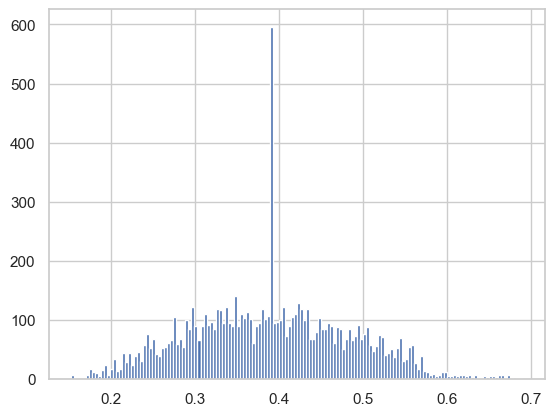

In [545]:
plt.hist(train_data.X4,bins=150);

filling nulls with the mean value creates a large spike due to the large number of nulls, so perhaps a KNN imputer would be a better approach since it will likely result in a distribution that's close to the original one

In [546]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,9.300000,LF,0.252232,Dairy,249.809204,049,1999,Medium,Tier 1,0,FDA
1,DRC01,5.920000,R,0.268136,Soft Drinks,48.269199,018,2009,Medium,Tier 3,2,DRC
2,FDN15,17.500000,LF,0.255913,Meat,141.617996,049,1999,Medium,Tier 1,0,FDN
3,FDX07,19.200001,R,0.389771,Fruits and Vegetables,182.095001,010,1998,NaN,Tier 3,1,FDX
4,NCD19,8.930000,LF,0.389771,Household,53.861401,013,1987,High,Tier 3,0,NCD


In [547]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(train_data_copy[['X2', 'X4', 'X6', 'X7', 'X8']]) # removing Y as well to avoid data leakage
data_imputed.shape

(8523, 5)

In [548]:
X4_imputed = data_imputed[:,1]

In [549]:
X4_imputed[0]

0.25223227917094393

In [550]:
train_data['X4'] = X4_imputed

In [551]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,9.300000,LF,0.252232,Dairy,249.809204,049,1999,Medium,Tier 1,0,FDA
1,DRC01,5.920000,R,0.268136,Soft Drinks,48.269199,018,2009,Medium,Tier 3,2,DRC
2,FDN15,17.500000,LF,0.255913,Meat,141.617996,049,1999,Medium,Tier 1,0,FDN
3,FDX07,19.200001,R,0.488011,Fruits and Vegetables,182.095001,010,1998,NaN,Tier 3,1,FDX
4,NCD19,8.930000,LF,0.425359,Household,53.861401,013,1987,High,Tier 3,0,NCD


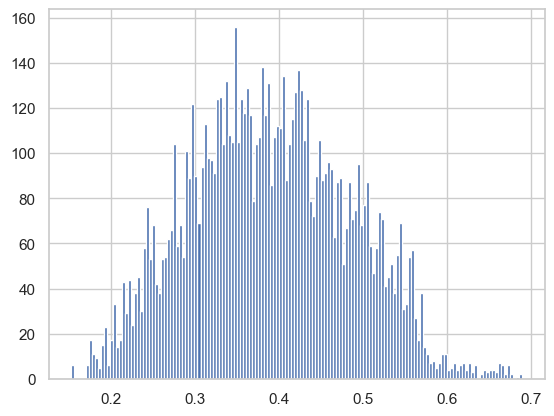

In [552]:
plt.hist(train_data['X4'], bins=150);

Number of null values in X2 before filling: 1463


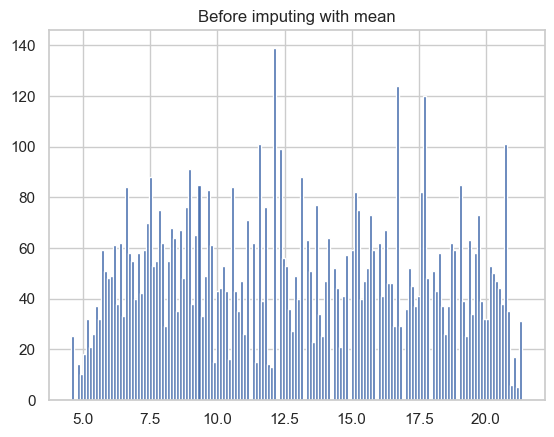

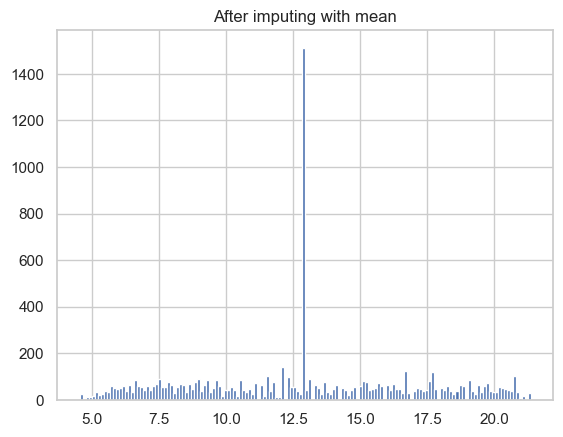

Number of null values in X2 after filling: 0


In [553]:
# Check for null values in X2
print(f"Number of null values in X2 before filling: {train_data['X2'].isnull().sum()}")

# Calculate the mean of X2 excluding NaN values
x2_mean = train_data['X2'].mean()

# Fill NaN values in X2 with the mean
plt.hist(train_data['X2'], bins=150); ## plotting it before imputing with mean
plt.title('Before imputing with mean')
plt.show()
train_data['X2'] = train_data['X2'].fillna(x2_mean)
plt.hist(train_data['X2'], bins=150, label='After imputing with mean'); ## plotting it before imputing with mean
plt.title('After imputing with mean')
plt.show()


# Check for null values after filling
print(f"Number of null values in X2 after filling: {train_data['X2'].isnull().sum()}")

The same spike issue persists here, so we'll adapt the same solution 

In [554]:
train_data['X2'] = data_imputed[:,0]

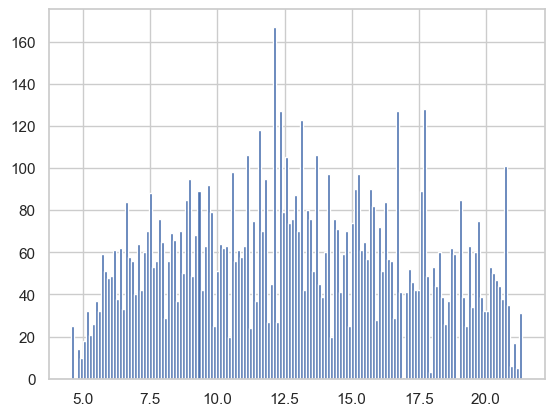

In [555]:
plt.hist(train_data['X2'], bins=150);

even the knn imputer doesnt seem to solve the issue.

In [556]:
# Encode values in X9
train_data['X9'] = train_data['X9'].replace({'High': 2, 'Medium': 1, 'Small': 0})
# Check for null values in X9 before filling
print(f"Number of null values in X9 before filling: {train_data['X9'].isnull().sum()}")

# Calculate the mode (most frequent value) of X9
x9_mode = train_data['X9'].mode()[0]  # mode()[0] gets the first mode value

# Fill NaN values in X9 with the mode
train_data['X9'] = train_data['X9'].fillna(x9_mode)

# Check for null values in X9 after filling
print(f"Number of null values in X9 after filling: {train_data['X9'].isnull().sum()}")
# Print the updated X9 column
print("Updated X9 column:")
print(train_data['X9'])

Number of null values in X9 before filling: 2410
Number of null values in X9 after filling: 0
Updated X9 column:
0       1.0
1       1.0
2       1.0
3       1.0
4       2.0
       ... 
8518    2.0
8519    1.0
8520    0.0
8521    1.0
8522    0.0
Name: X9, Length: 8523, dtype: float64


In [557]:
temp_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,2
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,0
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,1
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,0


In [558]:
# Convert the values in X7 to integers (removing leading zeros)
train_data['X7'] = train_data['X7'].astype(str).str.lstrip('0').astype(int)

# Print the updated X7 column
print("\nUpdated X7 column:")
print(train_data['X7'])


Updated X7 column:
0       49
1       18
2       49
3       10
4       13
        ..
8518    13
8519    45
8520    35
8521    18
8522    46
Name: X7, Length: 8523, dtype: int32


In [559]:
# Initialize the LabelEncoder
x5_encoder = LabelEncoder()

# Fit and transform the X5 column to label encoded values directly
train_data['X5'] = x5_encoder.fit_transform(train_data['X5'])

# Display the updated DataFrame with encoded 'X5' column
print("\nLabel Encoded 'X5' column:")
print(train_data[['X5']].head())


Label Encoded 'X5' column:
   X5
0   4
1  14
2  10
3   6
4   9


In [560]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,9.300000,LF,0.252232,4,249.809204,49,1999,1.0,Tier 1,0,FDA
1,DRC01,5.920000,R,0.268136,14,48.269199,18,2009,1.0,Tier 3,2,DRC
2,FDN15,17.500000,LF,0.255913,10,141.617996,49,1999,1.0,Tier 1,0,FDN
3,FDX07,19.200001,R,0.488011,6,182.095001,10,1998,1.0,Tier 3,1,FDX
4,NCD19,8.930000,LF,0.425359,9,53.861401,13,1987,2.0,Tier 3,0,NCD


In [561]:
# Encode 'LF' to 0 and 'R' to 1 in the X3 column
train_data['X3'] = train_data['X3'].map({'LF': 0, 'R': 1})

# Display the updated DataFrame with the 'X3' column now encoded
print("\nUpdated DataFrame with 'X3' encoded:")
print(train_data.head())


Updated DataFrame with 'X3' encoded:
      X1         X2  X3        X4  X5          X6  X7    X8   X9     X10  Y  \
0  FDA15   9.300000   0  0.252232   4  249.809204  49  1999  1.0  Tier 1  0   
1  DRC01   5.920000   1  0.268136  14   48.269199  18  2009  1.0  Tier 3  2   
2  FDN15  17.500000   0  0.255913  10  141.617996  49  1999  1.0  Tier 1  0   
3  FDX07  19.200001   1  0.488011   6  182.095001  10  1998  1.0  Tier 3  1   
4  NCD19   8.930000   0  0.425359   9   53.861401  13  1987  2.0  Tier 3  0   

  ProductType  
0         FDA  
1         DRC  
2         FDN  
3         FDX  
4         NCD  


In [562]:
# Encode 'Tier 1' to 0, 'Tier 2' to 1, and 'Tier 3' to 2 in the X10 column
train_data['X10'] = train_data['X10'].map({'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2})

# Display the updated DataFrame with the 'X10' column now encoded
print("\nUpdated DataFrame with 'X10' encoded:")
print(train_data.head())

#TODO: APPLY THIS TO TEST DATA


Updated DataFrame with 'X10' encoded:
      X1         X2  X3        X4  X5          X6  X7    X8   X9  X10  Y  \
0  FDA15   9.300000   0  0.252232   4  249.809204  49  1999  1.0    0  0   
1  DRC01   5.920000   1  0.268136  14   48.269199  18  2009  1.0    2  2   
2  FDN15  17.500000   0  0.255913  10  141.617996  49  1999  1.0    0  0   
3  FDX07  19.200001   1  0.488011   6  182.095001  10  1998  1.0    2  1   
4  NCD19   8.930000   0  0.425359   9   53.861401  13  1987  2.0    2  0   

  ProductType  
0         FDA  
1         DRC  
2         FDN  
3         FDX  
4         NCD  


In [563]:
# Initialize the LabelEncoder
PT_encoder = LabelEncoder()

# Fit and transform the 'ProductType' column in place
train_data['ProductType'] = PT_encoder.fit_transform(train_data['ProductType'])

# Display the mapping of original values to encoded values
product_type_mapping = dict(zip(PT_encoder.classes_, range(len(PT_encoder.classes_))))
print("\nMapping of ProductType values to labels:")
print(product_type_mapping)

#TODO: APPLY THIS TO TEST DATA



Mapping of ProductType values to labels:
{'DRA': 0, 'DRB': 1, 'DRC': 2, 'DRD': 3, 'DRE': 4, 'DRF': 5, 'DRG': 6, 'DRH': 7, 'DRI': 8, 'DRJ': 9, 'DRK': 10, 'DRL': 11, 'DRM': 12, 'DRN': 13, 'DRO': 14, 'DRP': 15, 'DRQ': 16, 'DRY': 17, 'DRZ': 18, 'FDA': 19, 'FDB': 20, 'FDC': 21, 'FDD': 22, 'FDE': 23, 'FDF': 24, 'FDG': 25, 'FDH': 26, 'FDI': 27, 'FDJ': 28, 'FDK': 29, 'FDL': 30, 'FDM': 31, 'FDN': 32, 'FDO': 33, 'FDP': 34, 'FDQ': 35, 'FDR': 36, 'FDS': 37, 'FDT': 38, 'FDU': 39, 'FDV': 40, 'FDW': 41, 'FDX': 42, 'FDY': 43, 'FDZ': 44, 'NCA': 45, 'NCB': 46, 'NCC': 47, 'NCD': 48, 'NCE': 49, 'NCF': 50, 'NCG': 51, 'NCH': 52, 'NCI': 53, 'NCJ': 54, 'NCK': 55, 'NCL': 56, 'NCM': 57, 'NCN': 58, 'NCO': 59, 'NCP': 60, 'NCQ': 61, 'NCR': 62, 'NCS': 63, 'NCT': 64, 'NCU': 65, 'NCV': 66, 'NCW': 67, 'NCX': 68, 'NCY': 69, 'NCZ': 70}


In [564]:
train_data.head()


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,9.300000,0,0.252232,4,249.809204,49,1999,1.0,0,0,19
1,DRC01,5.920000,1,0.268136,14,48.269199,18,2009,1.0,2,2,2
2,FDN15,17.500000,0,0.255913,10,141.617996,49,1999,1.0,0,0,32
3,FDX07,19.200001,1,0.488011,6,182.095001,10,1998,1.0,2,1,42
4,NCD19,8.930000,0,0.425359,9,53.861401,13,1987,2.0,2,0,48


In [565]:
# Select the numerical columns you want to standardize
numerical_columns = ['X2', 'X4', 'X6', 'X7','X5','ProductType', 'X8']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numerical columns
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])

# Display the updated DataFrame
print(train_data.head())

#TODO: APPLY THIS TO TEST DATA

      X1        X2  X3        X4        X5        X6        X7        X8   X9  \
0  FDA15 -0.828484   0 -1.442900 -0.766479  1.747454  1.428267  0.139541  1.0   
1  DRC01 -1.611439   1 -1.275956  1.608963 -1.489023 -0.797652  1.334103  1.0   
2  FDN15  1.070995   0 -1.404266  0.658786  0.010040  1.428267  0.139541  1.0   
3  FDX07  1.464789   1  1.032056 -0.291391  0.660050 -1.372083  0.020085  1.0   
4  NCD19 -0.914192   0  0.374399  0.421242 -1.399220 -1.156671 -1.293934  2.0   

   X10  Y  ProductType  
0    0  0    -1.040341  
1    2  2    -2.171152  
2    0  0    -0.175603  
3    2  1     0.489580  
4    2  0     0.888690  


In [566]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,FDA15,-0.828484,0,-1.442900,-0.766479,1.747454,1.428267,0.139541,1.0,0,0,-1.040341
1,DRC01,-1.611439,1,-1.275956,1.608963,-1.489023,-0.797652,1.334103,1.0,2,2,-2.171152
2,FDN15,1.070995,0,-1.404266,0.658786,0.010040,1.428267,0.139541,1.0,0,0,-0.175603
3,FDX07,1.464789,1,1.032056,-0.291391,0.660050,-1.372083,0.020085,1.0,2,1,0.489580
4,NCD19,-0.914192,0,0.374399,0.421242,-1.399220,-1.156671,-1.293934,2.0,2,0,0.888690


In [567]:
train_data = train_data.drop(['X1'], axis=1)

In [568]:
train_data.head()

,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y,ProductType
0,-0.828484,0,-1.442900,-0.766479,1.747454,1.428267,0.139541,1.0,0,0,-1.040341
1,-1.611439,1,-1.275956,1.608963,-1.489023,-0.797652,1.334103,1.0,2,2,-2.171152
2,1.070995,0,-1.404266,0.658786,0.010040,1.428267,0.139541,1.0,0,0,-0.175603
3,1.464789,1,1.032056,-0.291391,0.660050,-1.372083,0.020085,1.0,2,1,0.489580
4,-0.914192,0,0.374399,0.421242,-1.399220,-1.156671,-1.293934,2.0,2,0,0.888690


In [569]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   X2           8523 non-null   float64
 1   X3           8523 non-null   int64  
 2   X4           8523 non-null   float64
 3   X5           8523 non-null   float64
 4   X6           8523 non-null   float64
 5   X7           8523 non-null   float64
 6   X8           8523 non-null   float64
 7   X9           8523 non-null   float64
 8   X10          8523 non-null   int64  
 9   Y            8523 non-null   int8   
 10  ProductType  8523 non-null   float64
dtypes: float64(8), int64(2), int8(1)
memory usage: 674.3 KB


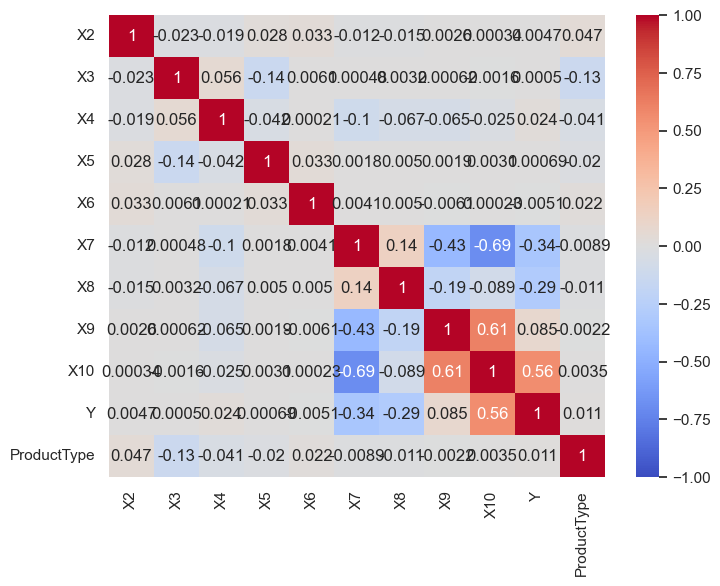

In [570]:
corr_matrix = train_data.select_dtypes(['number']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# Feature Importance

In [571]:

included_features = train_data.drop(['Y'], axis=1).columns
features = train_data[included_features].copy()
target = train_data['Y']

k_best = SelectKBest(score_func=f_regression, k=6)

X = k_best.fit_transform(features, target)
y = target
#Get the indices of the selected features
selected_features_indices = k_best.get_support(indices=True)

# Get the scores associated with each feature
feature_scores = k_best.scores_

In [572]:

# Create a list of tuples containing feature names and scores
feature_info = list(zip(features.columns, feature_scores))

# Sort the feature info in descending order based on scores
sorted_feature_info = sorted(feature_info, key=lambda x: x[1], reverse=True)

for feature_name, feature_score in sorted_feature_info[:10]:
    print(f"{feature_name}: {feature_score:.2f}")



X10: 3835.58
X7: 1127.60
X8: 805.38
X9: 61.47
X4: 5.09
ProductType: 1.10
X6: 0.22
X2: 0.19
X5: 0.00
X3: 0.00


In [573]:
best_features = ['X7', 'X8', 'X9', 'X10', 'Y']
train_data = train_data[best_features]

In [574]:
def apply_preprocessing_on_test_data(test_data: pd.DataFrame):

    def custom_preprocessing():

        test_data.X3.replace(['Low Fat', 'low fat'], 'LF', inplace=True)
        test_data.X3.replace(['Regular', 'reg'], 'R', inplace=True) 
        test_data['ProductType'] = test_data.X1.apply(lambda x : x[0:3])
        test_data.X7 = test_data.X7.apply(lambda x : x[3:])
        test_data.X4 = test_data.X4.apply(lambda x : np.cbrt(x))
        test_data['X4'] = test_data['X4'].replace(0, np.nan)
        test_data['X7'] = test_data['X7'].astype(str).str.lstrip('0').astype(int)
        test_data.drop(['X1'], axis=1, inplace=True)

    
        
    def encode():
        test_data['X9'] = test_data['X9'].replace({'High': 0, 'Medium': 1, 'Small': 2})
        test_data['X5'] = x5_encoder.transform(test_data['X5'])
        test_data['X3'] = test_data['X3'].map({'LF': 0, 'R': 1})
        test_data['X10'] = test_data['X10'].map({'Tier 1': 0, 'Tier 2': 1, 'Tier 3': 2})
        test_data['ProductType'] = PT_encoder.fit_transform(test_data['ProductType'])



    def fill_NA():

        data_imputed = imputer.transform(test_data[['X2', 'X4', 'X6', 'X7', 'X8']])
        test_data['X9'] = test_data['X9'].fillna(x9_mode)


    def normalize():
        test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])
    




    
    custom_preprocessing()
    encode()
    fill_NA()
    normalize()
    
    best_features = ['X7', 'X8', 'X9', 'X10']

    return test_data[best_features]

In [575]:
test_data = apply_preprocessing_on_test_data(test_data)

In [576]:
train_data.head()

,X7,X8,X9,X10,Y
0,1.428267,0.139541,1.0,0,0
1,-0.797652,1.334103,1.0,2,2
2,1.428267,0.139541,1.0,0,0
3,-1.372083,0.020085,1.0,2,1
4,-1.156671,-1.293934,2.0,2,0


In [577]:
test_data.head()

,X7,X8,X9,X10
0,1.428267,0.139541,1.0,0
1,-0.869456,1.095190,1.0,1
2,-1.372083,0.020085,1.0,2
3,-0.869456,1.095190,1.0,1
4,-0.151417,-1.532846,1.0,2


In [578]:
X_train, y_train = train_data.drop('Y', axis=1), train_data['Y']


# Outliers

# box plot for neumerical features 

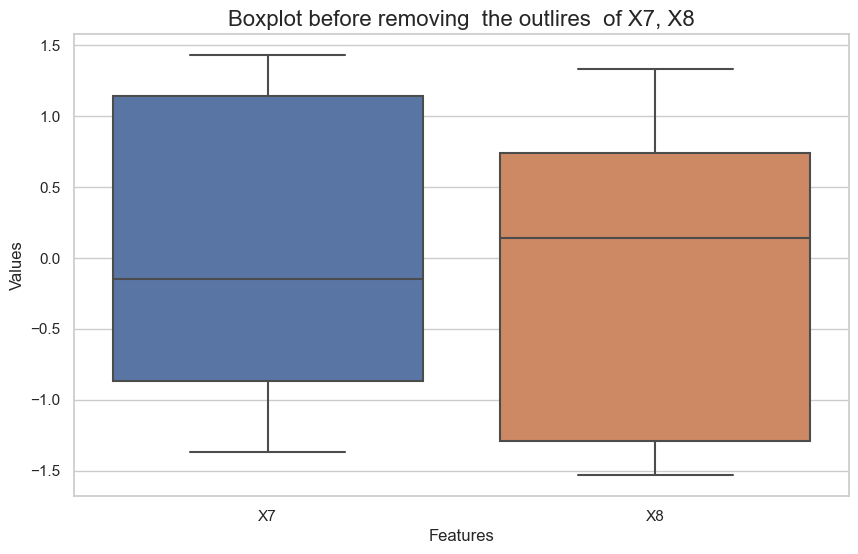

In [579]:


# style 
sns.set(style="whitegrid")

# Create a DataFrame for the neumerical features 
features_to_plot = ['X7','X8']
X_train_selected = X_train[features_to_plot]

# Create the box plot
plt.figure(figsize=(10, 6))  #  size
sns.boxplot(data=X_train_selected)

#  plot labels and title
plt.title('Boxplot before removing  the outlires  of X7, X8', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Values', fontsize=12)


plt.show()

apparently, no outliers are worth getting removed

In [580]:
# Calculate IQR for X_train (features)
Q1 = np.percentile(X_train, 25, axis=0)
Q3 = np.percentile(X_train, 75, axis=0)
IQR = Q3 - Q1

#  Define outlier condition for features
outliers = (X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))

# Print outliers 
outlier_rows = np.where(outliers.any(axis=1))  # Get rows with outliers in any feature

# Display the outlier rows and their corresponding labels
print("\nOutlier rows before applying any changes:")
print("Outlier rows in X_train:")
print(X_train.iloc[outlier_rows])

print("\nCorresponding labels in y_train:")
print(y_train.iloc[outlier_rows])

#  filter out the outliers from X_train and y_train 
X_train_cleaned = X_train[~outliers.any(axis=1)]  # Remove rows with outliers in any feature
y_train_cleaned = y_train[~outliers.any(axis=1)]  # Keep the corresponding labels intact

# Print the cleaned data shapes
print("\nOriginal X_train shape:", X_train.shape)
print("Cleaned X_train shape:", X_train_cleaned.shape)


Outlier rows before applying any changes:
Outlier rows in X_train:
Empty DataFrame
Columns: [X7, X8, X9, X10]
Index: []

Corresponding labels in y_train:
Series([], Name: Y, dtype: int8)

Original X_train shape: (8523, 4)
Cleaned X_train shape: (8523, 4)


#### According to "IQR outliers removing" method, no outliers were worth removeing

# Applying upsampling to balance the data

# Trying different models

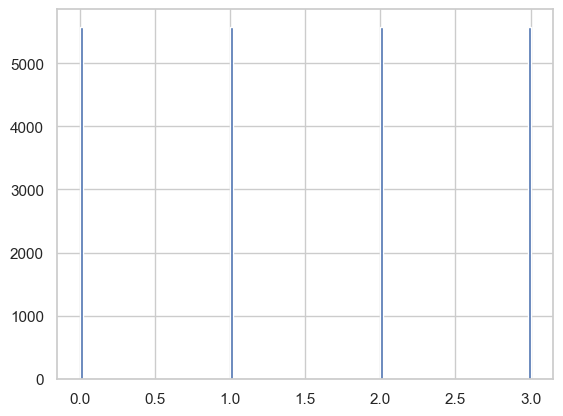

In [581]:
# Augmentation using SMOTE
smote = SMOTE(random_state=42)
X_train_augmented, y_train_augmented = smote.fit_resample(X_train_cleaned, y_train_cleaned)
X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented, random_state=42)

plt.hist(y_train_augmented,bins=150);


In [582]:
def train_and_evaluate_CV(model):
    CV = 5
    # Apply cross-validation with augmented data
    model_score = cross_val_score(model, X_train_augmented, y_train_augmented, scoring='accuracy', cv=5)
    print("Cross-validation scores with SMOTE:", model_score)
    return model

In [583]:
def convert_predictions_to_csv(predictions: np.ndarray, file_name):
    data = {'row_id' : [i for i in range(len(test_data))],
            'label': predictions.tolist()}
    
    output_df = pd.DataFrame(data)

    output_df.to_csv(file_name, index=False)

In [584]:
def train_on_full_data_and_export_csv(model, file_name):
    model.fit(X_train_augmented, y_train_augmented)
    predictions = model.predict(test_data)
    
    convert_predictions_to_csv(predictions, file_name)


In [585]:
def compare_equality_between_2csvs(csv1_path, csv2_path):
    df1 = pd.read_csv(csv1_path)
    df2 = pd.read_csv(csv2_path)
    pr1 = df1['label'].values
    pr2 = df2['label'].values
    differences = pr1 - pr2
    sum_ = sum([x!=0 for x in differences])
    print('equal') if np.array_equal(pr1, pr2) else print(f'unequal: {sum_}' )

In [586]:
compare_equality_between_2csvs('logistic_preds.csv', 'NeuralNet.csv')

equal


In [587]:
NaiveBayes = GaussianNB(var_smoothing=0.001)
train_and_evaluate_CV(NaiveBayes)

Cross-validation scores with SMOTE: [0.96122815 0.95428059 0.96302107 0.955167   0.95740865]


GaussianNB(var_smoothing=0.001)

In [588]:
train_on_full_data_and_export_csv(NaiveBayes, 'naive.csv')

In [589]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()
train_and_evaluate_CV(model)

Cross-validation scores with SMOTE: [0.7902286  0.78776333 0.7933662  0.78255996 0.78211163]


BernoulliNB()

In [590]:
gaussian_mixture = GaussianMixture(n_components=4, random_state=RandomState)
train_and_evaluate_CV(gaussian_mixture)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\mixture\_base.py", line 181, in fit
    self.fit_predict(X, y)
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\mixture\_base.py", line 235, in fit_predict
    self._initialize_parameters(X, random_state)
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\mixture\_gaussian_mixture.py", line 766, in _initialize_parameters
    super()._initialize_parameters(X, random_state)
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\mixture\_base.py", line 118, in _initialize_parameters
    .fit(X)
     ^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py", line 1536, in fit
    labels, inertia, centers, n_iter_ = kmeans_single(
                                        ^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py", line 702, in _kmeans_single_lloyd
    with threadpool_limits(limits=1, user_api="blas"):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\utils\fixes.py", line 94, in threadpool_limits
    return threadpoolctl.threadpool_limits(limits=limits, user_api=user_api)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\threadpoolctl.py", line 171, in __init__
    self._original_info = self._set_threadpool_limits()
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\threadpoolctl.py", line 268, in _set_threadpool_limits
    modules = _ThreadpoolInfo(prefixes=self._prefixes,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\threadpoolctl.py", line 340, in __init__
    self._load_modules()
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\threadpoolctl.py", line 373, in _load_modules
    self._find_modules_with_enum_process_module_ex()
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\threadpoolctl.py", line 485, in _find_modules_with_enum_process_module_ex
    self._make_module_from_path(filepath)
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "c:\Users\mahmo\anaconda3\Lib\site-packages\threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


In [591]:
train_on_full_data_and_export_csv(gaussian_mixture, 'gauss_mix.csv')

AttributeError: 'NoneType' object has no attribute 'split'

what a shame

In [592]:
from sklearn.preprocessing import KBinsDiscretizer

# Discretize features into 3 bins as an example
disc = KBinsDiscretizer(n_bins=40, encode='ordinal', strategy='uniform')
Y = train_data['Y']
train_data_discrete = disc.fit_transform(train_data.drop(['Y'], axis=1))
test_data_discrete = disc.transform(test_data)

# Convert back to DataFrame
train_data = pd.DataFrame(train_data_discrete, columns=train_data.drop(['Y'], axis=1).columns)
test_data = pd.DataFrame(test_data_discrete, columns=test_data.columns)
train_data['Y'] = Y

c:\Users\mahmo\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

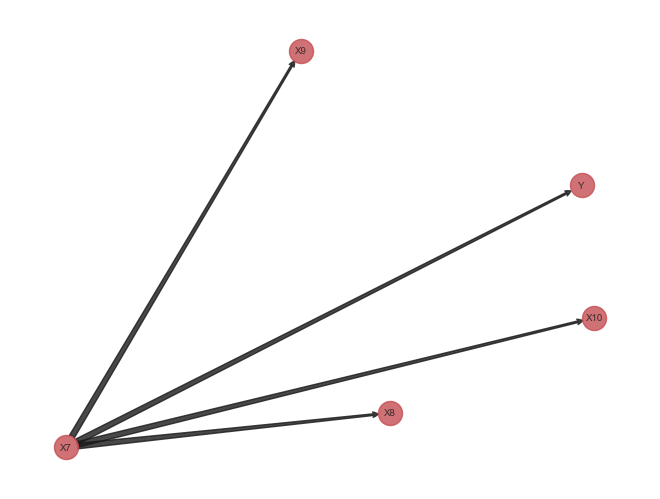

In [593]:
from pgmpy.estimators import TreeSearch
import networkx as nx
est = TreeSearch(train_data)  #  automatic selection for the root node 
dag = est.estimate(estimator_type='chow-liu', )

# Visualize 
pos = nx.spiral_layout(dag)  
nx.draw(dag, pos=pos, with_labels=True, node_color='r', font_size=7, arrowstyle='fancy', alpha=0.8)

# Save the plot
plt.savefig('plt.png', dpi=700)
plt.show()





In [594]:
bayesian_model = BayesianNetwork(dag)
bayesian_model.fit(train_data)
p = bayesian_model.predict(test_data)

  0%|          | 0/10 [00:00<?, ?it/s]

In [595]:
p['Y'].to_numpy().max()

3

In [596]:
data = {'row_id' : [i for i in range(len(test_data))],
        'label': p['Y'].tolist()}

output_df = pd.DataFrame(data)

output_df.to_csv('BayesianNetwork.csv', index=False)

In [597]:
compare_equality_between_2csvs('BayesianNetwork.csv', 'NeuralNet.csv')

equal


In [598]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
train_and_evaluate_CV(LDA)

Cross-validation scores with SMOTE: [0.9148364  0.91954281 0.91438817 0.92221475 0.91302399]


LinearDiscriminantAnalysis()

In [599]:
train_on_full_data_and_export_csv(LDA, 'LDA.csv')

In [600]:
compare_equality_between_2csvs('LDA.csv', 'NeuralNet.csv')

unequal: 1960


In [612]:
from hmmlearn import hmm
model = hmm.GaussianHMM(n_components=4, n_iter=100)

model.fit(X_train.to_numpy())

AttributeError: 'NoneType' object has no attribute 'split'